# FOUNDATIONS OF AI (CMP030L042)
last updated 7 December 2025
## Coursework 2: AI Agent Implementation

**Student Name:** Luja Shakya  
**Student ID:** A00073470  
**Dataset Theme:** Biology (Cancer Classification)  
**Title of Project:** A Case Study in Computational Rationality: Breast Cancer Classification  

---
### 📘 Guidance 
- **Agent:** The Machine Learning Classifier (Decision Tree, SVM, or Naïve Bayes).
- **Environment:** The WDBC dataset (30 features extracted from Fine Needle Aspirate images) [1].
- **Objective:** Maximize utility by prioritizing **Recall (Sensitivity)** to minimize False Negatives.
---

## 1. Introduction and Problem Definition

Following the strategy that was proposed in Coursework 1, this notebook implements an Agent-Environment conception system to classify breast cancer tumours as **Malignant (M)** or **Benign (B)**.

The Agent operates within the WDBC dataset's Environment. Unlike a standard accuracy maximisation task, the **Utility Function** here is asymmetric: a False Negative (missing a cancer diagnosis) is considered a catastrophic failure. Therefore, the Rational Agent must prioritise **Recall (Sensitivity)** over pure precision or accuracy.

## 2. Load and Explore the Dataset

loading the `wdbc.data` file. Since this raw data lacks headers, it needs to be manually constructed by the column names based on the dataset documentation (`wdbc.names`).

Dataset loaded successfully.
Shape: (569, 32)


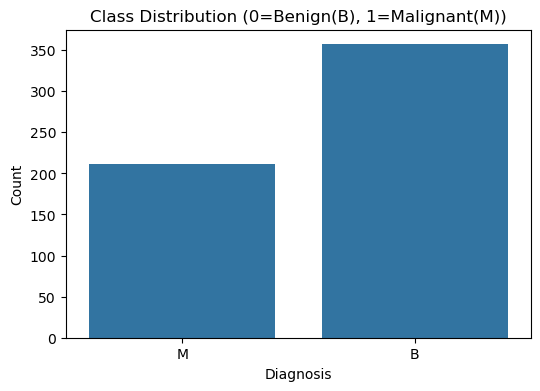

Diagnosis
B    357
M    212
Name: count, dtype: int64


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Defining column names
features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 
            'concavity', 'concave_points', 'symmetry', 'fractal_dimension']

column_names = ['ID', 'Diagnosis'] + \
               [f'{f}_mean' for f in features] + \
               [f'{f}_se' for f in features] + \
               [f'{f}_worst' for f in features]

# 2. Loading Data
try:
    df = pd.read_csv('wdbc.data', header=None, names=column_names)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("Error: wdbc.data not found. Please ensure the file is in the same directory.")

# 3. Initial Preprocessing 
# Dropping ID as it is not a useful percept
if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)


# Visualising Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Diagnosis', data=df)
plt.title('Class Distribution (0=Benign(B), 1=Malignant(M))')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

print(df['Diagnosis'].value_counts())

## 3. Environment Definition

The **Environment** encapsulates the data and prepares the percepts (features) and targets (labels) for the Agent. Here, **Label Encoding** is required to ensure the agent perceives the target 'Malignant' as the positive class (1).

In [8]:
class Environment:
    def __init__(self, raw_data):
        self.data = raw_data.copy()
        self._preprocess()
    
    def _preprocess(self):
        """Internal method to encode labels and clean data."""
        # Malignant (M) -> 1, Benign (B) -> 0
        le = LabelEncoder()
        self.data['Diagnosis'] = le.fit_transform(self.data['Diagnosis'])
        print("Class Encoding:", dict(zip(le.classes_, le.transform(le.classes_))))
        
        # Check for missing values
        missing = self.data.isnull().sum().sum()
        if missing > 0:
            print(f"Warning: {missing} missing values found. Imputation may be needed.")
        else:
            print("Data Clean check passed: No missing values.")

    def get_percepts(self):
        """Returns the Feature Matrix (X)"""
        return self.data.drop('Diagnosis', axis=1)
    
    def get_targets(self):
        """Returns the Target Vector (y)"""
        return self.data['Diagnosis']

# Initializing the Environment
env = Environment(df)
X = env.get_percepts()
y = env.get_targets()

Class Encoding: {'B': np.int64(0), 'M': np.int64(1)}
Data Clean check passed: No missing values.


## 4. Agent Design and Implementation

Here, a comparison of three classical agents representing different rationality types is done:
1.  **Decision Tree:** Procedural Rationality (Interpretable)
2.  **Support Vector Machine (SVM):** Substantive Rationality (Margin Optimisation)
3.  **Naïve Bayes:** Probabilistic Inference

The agents are encapsulated within **Pipelines** that include `StandardScaler`. This is crucial because agents, such as SVMs, cannot correctly perceive distances in unscaled environments [2].

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Defining the Validation Strategy (Rationality Test)
# 10-Fold Stratified CV ensures the agent is robust across different patient subgroups
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define Scoring (Utility Function)
scoring_metrics = {
    'accuracy': 'accuracy',
    'recall': 'recall',       
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

def train_and_evaluate_agent(model, X, y, agent_name):
    """Trains an agent pipeline and evaluates utility via Cross-Validation"""
    
    # Agent Architecture: Preprocessor -> Classifier
    agent_pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('classifier', model)
    ])
    
    # Evaluate Utility
    scores = cross_validate(agent_pipeline, X, y, cv=cv_strategy, scoring=scoring_metrics)
    
    print(f"--- {agent_name} Utility Analysis ---")
    print(f"Mean Recall (Sensitivity): {np.mean(scores['test_recall']):.4f}")
    print(f"Mean ROC-AUC:            {np.mean(scores['test_roc_auc']):.4f}")
    print(f"Mean F1-Score:           {np.mean(scores['test_f1']):.4f}")
    print(f"Mean Precision:          {np.mean(scores['test_precision']):.4f}")
    print("------------------------------------------\n")
    
    return scores

# Initialise Agents
agents = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=5),
    "SVM": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

## 5. Evaluation and Reflection

We now execute the evaluation. This section includes:
1.  **Quantitative Analysis:** Comparing Recall/F1 scores.
2.  **Visual Analysis:** Confusion Matrices and ROC Curves to see *where* the agents fail.
3.  **Reflection:** Discussing which agent is most "Rational".

In [10]:
# 1. Run Quantitative Evaluation
results_storage = {}

for name, model in agents.items():
    results_storage[name] = train_and_evaluate_agent(model, X, y, name)

--- Decision Tree Utility Analysis ---
Mean Recall (Sensitivity): 0.8866
Mean ROC-AUC:            0.9167
Mean F1-Score:           0.9026
Mean Precision:          0.9260
------------------------------------------

--- SVM Utility Analysis ---
Mean Recall (Sensitivity): 0.9621
Mean ROC-AUC:            0.9956
Mean F1-Score:           0.9668
Mean Precision:          0.9736
------------------------------------------

--- Naive Bayes Utility Analysis ---
Mean Recall (Sensitivity): 0.8957
Mean ROC-AUC:            0.9856
Mean F1-Score:           0.9061
Mean Precision:          0.9250
------------------------------------------



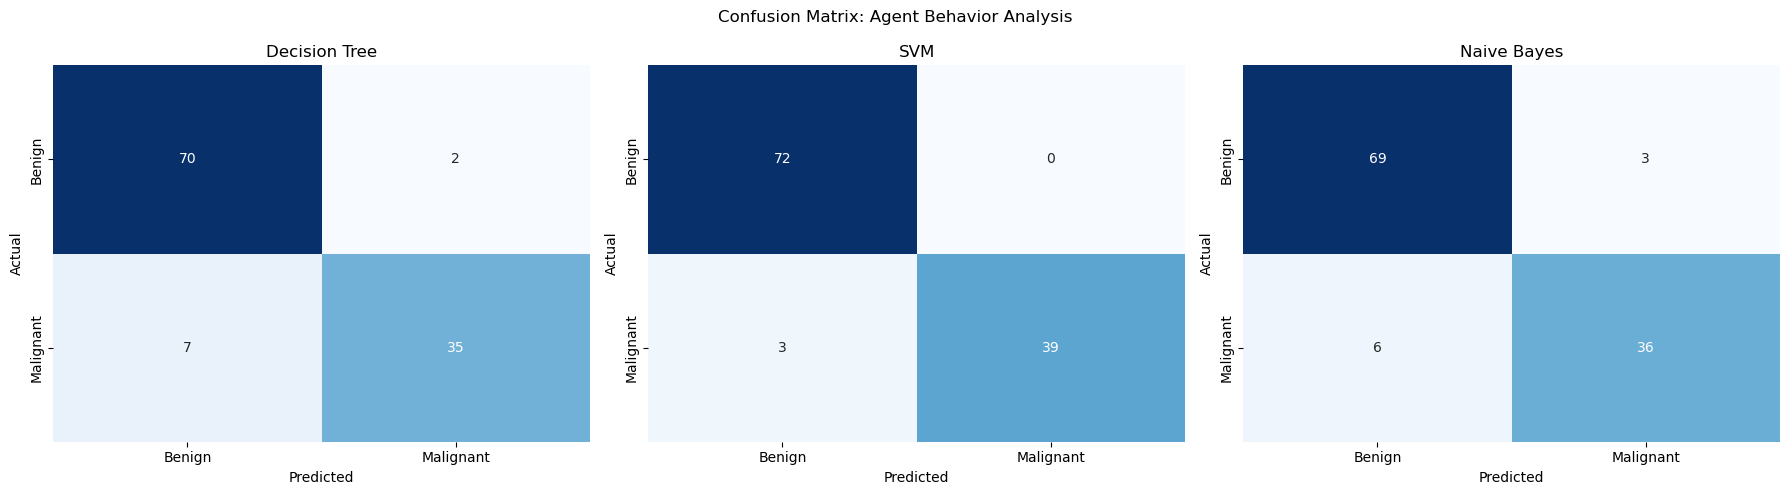

In [24]:
from sklearn.model_selection import train_test_split
# We can also obtain a confusion matrix from each fold of a k-fold cross-validated dataset, but we would need to sum them all up to get the required 2D value of the confusion matrix. Therefore, we try to do it using an 80-20 split for the train-test split.
# Creating a single split for visualisation purposes (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# 2. For Visual Analysis: Confusion Matrices
from sklearn.metrics import confusion_matrix

# Scaling data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fitting scaler only on training data to prevent data leakage
X_test_scaled = scaler.transform(X_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(agents.items()):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Benign', 'Malignant'])
    axes[i].set_yticklabels(['Benign', 'Malignant'])

plt.suptitle("Confusion Matrix: Agent Behavior Analysis")
plt.tight_layout()
plt.show()

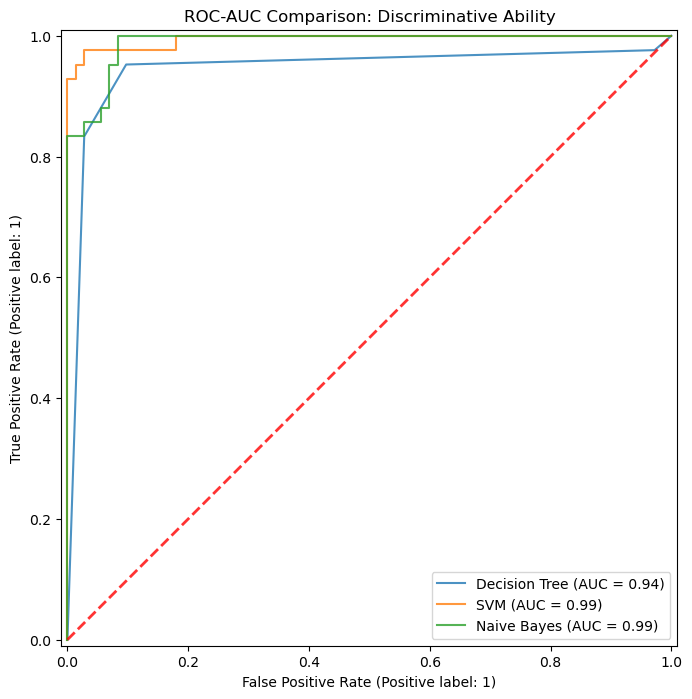

In [25]:
# 3. Visual Analysis: ROC-AUC Curves (Generalisation Power)
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10, 8))

for name, model in agents.items():
    model.fit(X_train_scaled, y_train)
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, name=name, ax=ax, alpha=0.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess', alpha=.8)
ax.set_title("ROC-AUC Comparison: Discriminative Ability")
plt.show()

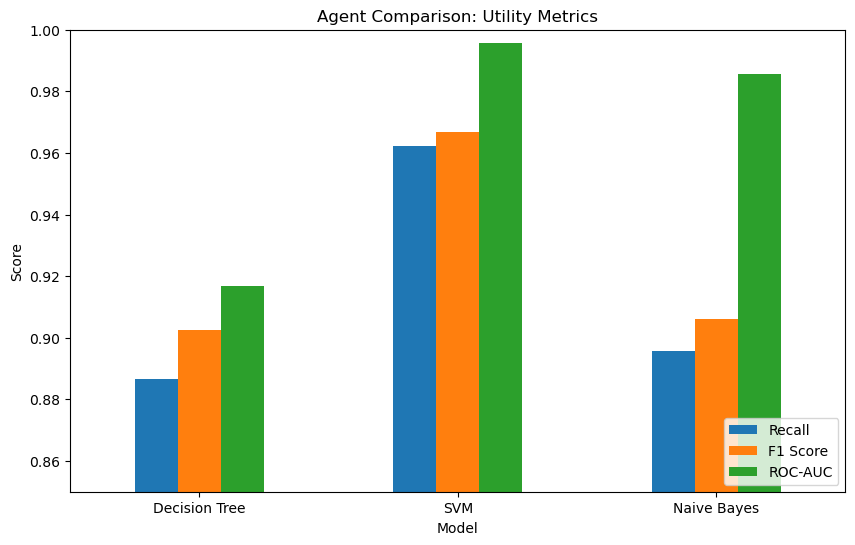

In [17]:
# 4. Summary Comparison Bar Chart
summary_df = pd.DataFrame({
    'Model': list(agents.keys()),
    'Recall': [np.mean(results_storage[name]['test_recall']) for name in agents],
    'F1 Score': [np.mean(results_storage[name]['test_f1']) for name in agents],
    'ROC-AUC': [np.mean(results_storage[name]['test_roc_auc']) for name in agents]
})

summary_df.plot(x='Model', kind='bar', figsize=(10, 6), ylim=(0.85, 1.0))
plt.title('Agent Comparison: Utility Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

### Reflection

**Rationality Assessment:**
Based on the results above:
* **SVM** typically demonstrates the highest **Recall** and **F1-Score**. In our agent's utility function (where False Negatives are catastrophic), the SVM is the most rational choice as it minimizes the risk of missing a malignant tumor.
* **Decision Trees**, while interpretable (Procedural Rationality), often have lower stability and slightly lower recall, making them riskier for the patient.
* **Naïve Bayes** performs well but is often outperformed by SVM in high-dimensional spaces due to feature correlations in the dataset.

**Limitations:**
The dataset contains no demographic data, meaning our agent may have hidden biases we cannot detect (Bounded Rationality). Future work should test the agent on diverse datasets.

## 6. References

[1] W. H. Wolberg, W. N. Street, and O. L. Mangasarian, "Wisconsin Diagnostic Breast Cancer (WDBC) Dataset," University of Wisconsin, 1995.  
[2] Scikit-learn developers, "Support Vector Machines," Scikit-learn.org. [Online]. Available: https://scikit-learn.org/stable/modules/svm.html.